___
## ABC Classification

Using the Tableau SuperStore dataset 

Data
The Super Store dataset contains data on order details of customers for orders of a superstore in the US. This includes the state, region, order date, shipping date, product ordered etc.

The steps that we will be doing here are :
- **Generate the ABC classifcation by Region and Category for the products**
- **Create coefficient of variation for the products**
- **Perform an EDA on the ABC classification**
- **Litrature on the application of ABC / coefficient of variation in Supply chain**


In [94]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import datetime, timedelta
%matplotlib inline

___
### Read in data

In [95]:
df = pd.read_csv('Superstore\superstore.csv', encoding='latin')

___
## Exploratory data analysis

### The below look into the data show us that this is a sales dataset with the most granular level information - [Order, Customer, Product] level

In [96]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,09-11-13,12-11-13,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,09-11-13,12-11-13,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,13-06-13,17-06-13,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,11-10-12,18-10-12,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,11-10-12,18-10-12,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [98]:
# Converting the dates to date format
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

### The summary statistics of the measure variables suggest that the range of the prducts the profitability and the volume normally bought by the customers

In [99]:
df.drop(['Row ID','Postal Code'], axis=1).describe()

,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000
mean,229.858001,3.789574,0.156203,28.656896
std,623.245101,2.225110,0.206452,234.260108
min,0.444000,1.000000,0.000000,-6599.978000
25%,17.280000,2.000000,0.000000,1.728750
50%,54.490000,3.000000,0.200000,8.666500
75%,209.940000,5.000000,0.200000,29.364000
max,22638.480000,14.000000,0.800000,8399.976000


### Literature : ABC Classification

The ABC classification follows the power law y=ax^k which says Distribution of many phenomena across a population follow a Power Law relationship.

These can be seen in from various examples in our daily life
Severity of hurricanes and earthquakes
* Income within a population (Pareto’s Law)
* Visits to websites (Nielsen’s Law) & blogs
* Frequency of words in any language (Zipf’s Law)
* Frequency of digits within tables (Benford’s Law)
* Frequency of authors citations in literature (Lotka’s Law)
* Profitability of customers & products
* Questions from students in a class

> ***The important few versus the trivial many***

#### We assume that Superstore has operations (Supply Network) is divided into regions in USA and each region has dedicated infrastructure to manage the demand from the its corresponding area.
#### Then with the above information we look at how can we calculate ABC classification of the products of Superstore in each of the Region and Category 

In [100]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [101]:
### For ABC Calculations we only need last 6 months of data

In [102]:
abcvol = df[df['Order Date'] > (df['Order Date'].max() - timedelta(days=180))]
cols = ['Region','Category','Product ID','Sales']
abcvol = abcvol[cols]

In [103]:
abcvol.head()

,Region,Category,Product ID,Sales
23,East,Furniture,FUR-CH-10002774,71.372
34,Central,Office Supplies,OFF-PA-10000249,29.472
41,Central,Technology,TEC-PH-10004093,147.168
43,South,Office Supplies,OFF-ST-10003282,95.616
71,Central,Office Supplies,OFF-PA-10004675,19.050


### Here we aggregate the data at a ['Region','Category', 'Product ID'] since we have customer order level information.

In [104]:
abcvol = abcvol.pivot_table(values=['Sales'], index=['Region','Category', 'Product ID'], aggfunc='sum')
abcvol.reset_index(inplace=True)

#### The below is a recursive function used to calculate the ABC Class

In [105]:
def abcregion(abcvol, x=0.8, y=0.15, z=.05):
    sc=abcvol['Region'].unique()
    for i,j in enumerate(sc):
        tempsc = abcvol.loc[abcvol['Region']==j,]
        if (i == 0):
            abc1 = abccategory(tempsc,x,y,z)
        else:
            abc1 = pd.concat([abc1, abccategory(tempsc,x,y,z)])
    return abc1

def abccategory(abcvol, x=0.8, y=0.15, z=.05):
    sc=abcvol['Category'].unique()
    for i,j in enumerate(sc):
        tempsc = abcvol.loc[abcvol['Category']==j,]
        if (i == 0):
            abc2 = abcproduct(tempsc,x,y,z)
        else:
            abc2 = pd.concat([abc2, abcproduct(tempsc,x,y,z)])
    return abc2

def abcproduct(abcvol, x=0.8, y=0.15, z=.05):
    data = abcvol
    data = data.sort_values(by='Sales',ascending=False)
    data['CumSum'] = np.cumsum(data['Sales'].sort_values(ascending=False).values)
    total = data['Sales'].sum()
    count = data.shape[0]
    acutoff = x * total
    bcutoff = acutoff + (y * total)
    ccutoff = bcutoff + (z * total)
    data['ABC'] = 'D'
    data.loc[(data['CumSum'] <= acutoff) & (data['ABC'] == "D"),'ABC'] = "A"
    data.loc[(data['CumSum'] <= bcutoff) & (data['ABC'] == "D"),'ABC'] = "B"
    data.loc[data['ABC'] == "D",'ABC'] = "C"
    
    return data


In [106]:
abc = abcregion(abcvol).rename({'CumSum':'Sales Cumulative'}, axis=1).reset_index(drop=True)

### View into the generated dataset with the ABC Classification

In [107]:
abc.head()

,Region,Category,Product ID,Sales,Sales Cumulative,ABC
0,Central,Furniture,FUR-CH-10002335,1586.690,1586.690,A
1,Central,Furniture,FUR-CH-10004086,1458.650,3045.340,A
2,Central,Furniture,FUR-CH-10003973,1040.928,4086.268,A
3,Central,Furniture,FUR-TA-10000577,974.988,5061.256,A
4,Central,Furniture,FUR-TA-10002228,933.408,5994.664,A


In [108]:
abc.to_csv('abc.csv', index=False)

### Aggregation of the Sales Generated for different Region/Categories for each ABC. Note the high values in the A Class and the low values in the C class

In [109]:
abc.pivot_table(values='Sales', index=['Region','Category'], columns='ABC', aggfunc='sum', margins='all').iloc[:-1]

ABC                               A          B          C         All
Region  Category                                                     
Central Furniture        19482.9988  3737.3132  1301.1558  24521.4678
        Office Supplies  21099.3600  4063.6940  1333.9240  26496.9780
        Technology       16220.9160  3022.0140  1098.7900  20341.7200
East    Furniture        30963.2930  5923.1990  2027.8030  38914.2950
        Office Supplies  34865.1950  6655.1180  2194.6440  43714.9570
        Technology       47761.9290  9370.1100  3013.1110  60145.1500
South   Furniture        15322.7275  2978.3740  1077.2920  19378.3935
        Office Supplies  23084.8380  4520.0290  1465.7370  29070.6040
        Technology       11450.0380  2413.8240   729.7400  14593.6020
West    Furniture        32653.9870  6439.8240  2064.2450  41158.0560
        Office Supplies  38682.7960  7265.4720  2435.9330  48384.2010
        Technology       34679.8150  6782.9600  2281.9640  43744.7390

### The percenage of sales for the different class in each region and Category
### e.g. Central / Furniture A=79.93% B=14.98% C=5.09% ~ 100% (Due to rounding off)

In [110]:
pd.crosstab(values=abc.Sales, index=[abc.Region,abc.Category], columns=abc.ABC, aggfunc='sum',normalize='index').round(4)*100

ABC                          A      B     C
Region  Category                           
Central Furniture        79.45  15.24  5.31
        Office Supplies  79.63  15.34  5.03
        Technology       79.74  14.86  5.40
East    Furniture        79.57  15.22  5.21
        Office Supplies  79.76  15.22  5.02
        Technology       79.41  15.58  5.01
South   Furniture        79.07  15.37  5.56
        Office Supplies  79.41  15.55  5.04
        Technology       78.46  16.54  5.00
West    Furniture        79.34  15.65  5.02
        Office Supplies  79.95  15.02  5.03
        Technology       79.28  15.51  5.22

### Now lets look at the distribution of the SKU's in each of the classifications
Most of the time you can see that the numbers in B and C class are higher than A class

In [111]:
abc.pivot_table(values='Sales', index=['Region','Category'], columns='ABC', aggfunc='count', margins='all').iloc[:-1]

ABC                       A   B    C  All
Region  Category                         
Central Furniture        32  17   30   79
        Office Supplies  41  75  100  216
        Technology       20  20   22   62
East    Furniture        28  30   45  103
        Office Supplies  38  90  142  270
        Technology       22  28   47   97
South   Furniture        19  12   25   56
        Office Supplies  32  49   91  172
        Technology       13  15   16   44
West    Furniture        39  31   47  117
        Office Supplies  56  95  153  304
        Technology       31  29   36   96

### Looking at the % spread of the SKU's 

In [112]:
pd.crosstab(values=abc.Sales, index=[abc.Region,abc.Category], columns=abc.ABC, aggfunc='count',normalize='index')

ABC                             A         B         C
Region  Category                                     
Central Furniture        0.405063  0.215190  0.379747
        Office Supplies  0.189815  0.347222  0.462963
        Technology       0.322581  0.322581  0.354839
East    Furniture        0.271845  0.291262  0.436893
        Office Supplies  0.140741  0.333333  0.525926
        Technology       0.226804  0.288660  0.484536
South   Furniture        0.339286  0.214286  0.446429
        Office Supplies  0.186047  0.284884  0.529070
        Technology       0.295455  0.340909  0.363636
West    Furniture        0.333333  0.264957  0.401709
        Office Supplies  0.184211  0.312500  0.503289
        Technology       0.322917  0.302083  0.375000

In [113]:
### Plotting the ABC classification
plt.rcParams['figure.figsize']=8,6

> From the below plots we can see that the A class items drives the majority of the sales for the company and it has comparitatively lower number of SKU's associated with it. Hence manging them better is of utmost importance.

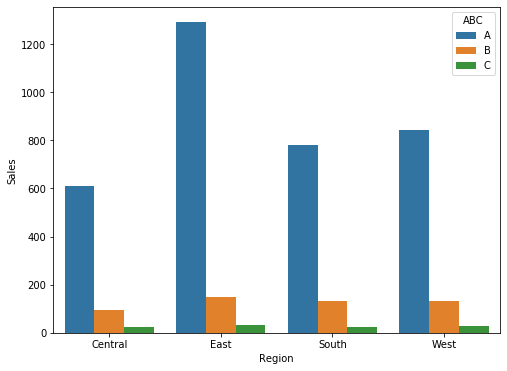

In [114]:
sns.barplot(data = abc,x = 'Region',y = 'Sales',hue = 'ABC',ci = None);

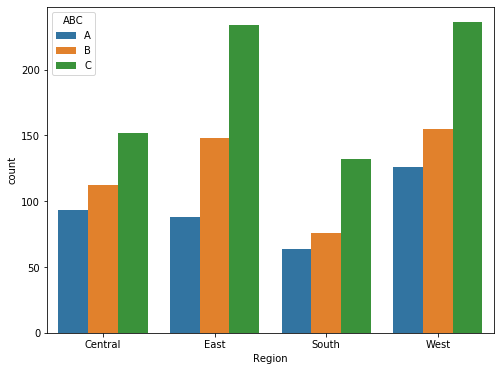

In [115]:
sns.countplot(data = abc,x = 'Region',hue = 'ABC');

>  A single ABC categorization provides a snapshot based on a single parameter, for example turnover. It is not enough to evaluate a product, take this example: Two products can have the same turnover, but act very differently.




> To get a better overview, you need to evaluate a product on at least 2 parameters: Ordering variation and turnover. You do this by making two single ABC categorizations which you combine. Then you have a double ABC categorization.

> This is done by calculating the coefficient of variation of the ordering of the SKU. e.g. consider two similar A class item with one periodically ordered every month and the other have sporadic ordering patterns. In such cases extra effort and time needs to be deicated to the sporadic SKU since the stable SKU's is more predictable. In terms of C Class SKU we need to look into if we really need such sporadic demand SKU's

In [116]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2013-152156,2013-09-11,2013-12-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2013-152156,2013-09-11,2013-12-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2013-138688,2013-06-13,2013-06-17,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2012-108966,2012-11-10,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2012-108966,2012-11-10,2012-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


### Calculating Order Lines

In [117]:
coefvol = df[df['Order Date'] > (df['Order Date'].max() - timedelta(days=360))]
cols = ['Region','Category','Product ID','Quantity']
coefvol = coefvol[cols]
coefvol.reset_index(inplace=True, drop=True)

In [118]:
coefvol.head()

,Region,Category,Product ID,Quantity
0,South,Office Supplies,OFF-PA-10002365,3
1,East,Furniture,FUR-CH-10002774,2
2,Central,Office Supplies,OFF-PA-10000249,3
3,Central,Technology,TEC-PH-10004093,4
4,South,Office Supplies,OFF-ST-10003282,2


In [119]:
coefvol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Region      3279 non-null   object
 1   Category    3279 non-null   object
 2   Product ID  3279 non-null   object
 3   Quantity    3279 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 102.6+ KB


In [120]:
coefvol = coefvol.pivot_table(values=['Quantity'], index=['Region','Category', 'Product ID'], aggfunc='count')
coefvol = coefvol.reset_index()
coefvol.head()

,Region,Category,Product ID,Quantity
0,Central,Furniture,FUR-BO-10000112,1
1,Central,Furniture,FUR-BO-10000780,1
2,Central,Furniture,FUR-BO-10001601,2
3,Central,Furniture,FUR-BO-10001608,1
4,Central,Furniture,FUR-BO-10001811,2


In [121]:
coefvol.describe()

,Quantity
count,2625.000000
mean,1.249143
std,0.526385
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,5.000000


In [122]:
coefvol['Quantity'].value_counts()

1    2074
2     462
3      76
4      12
5       1
Name: Quantity, dtype: int64

In [123]:
def abcregion(abcvol, x=0.8, y=0.15, z=.05):
    sc=abcvol['Region'].unique()
    for i,j in enumerate(sc):
        tempsc = abcvol.loc[abcvol['Region']==j,]
        if (i == 0):
            abc1 = abccategory(tempsc,x,y,z)
        else:
            abc1 = pd.concat([abc1, abccategory(tempsc,x,y,z)])
    return abc1

def abccategory(abcvol, x=0.8, y=0.15, z=.05):
    sc=abcvol['Category'].unique()
    for i,j in enumerate(sc):
        tempsc = abcvol.loc[abcvol['Category']==j,]
        if (i == 0):
            abc2 = abcproduct(tempsc,x,y,z)
        else:
            abc2 = pd.concat([abc2, abcproduct(tempsc,x,y,z)])
    return abc2

def abcproduct(abcvol, x=0.8, y=0.15, z=.05):
    data = abcvol
    data = data.sort_values(by='Quantity',ascending=False)
    data['CumSum'] = np.cumsum(data['Quantity'].sort_values(ascending=False).values)
    total = data['Quantity'].sum()
    count = data.shape[0]
    acutoff = x * total
    bcutoff = acutoff + (y * total)
    ccutoff = bcutoff + (z * total)
    data['ABC'] = 'D'
    data.loc[(data['CumSum'] <= acutoff) & (data['ABC'] == "D"),'ABC'] = "A"
    data.loc[(data['CumSum'] <= bcutoff) & (data['ABC'] == "D"),'ABC'] = "B"
    data.loc[data['ABC'] == "D",'ABC'] = "C"
    
    return data


In [129]:
abclines = abcregion(coefvol).rename({'CumSum':'Sales Cumulative'}, axis=1).reset_index(drop=True)

In [130]:
abclines.head()

,Region,Category,Product ID,Quantity,Sales Cumulative,ABC
0,Central,Furniture,FUR-TA-10001676,2,2,A
1,Central,Furniture,FUR-FU-10000293,2,4,A
2,Central,Furniture,FUR-FU-10004091,2,6,A
3,Central,Furniture,FUR-CH-10003973,2,8,A
4,Central,Furniture,FUR-CH-10003774,2,10,A


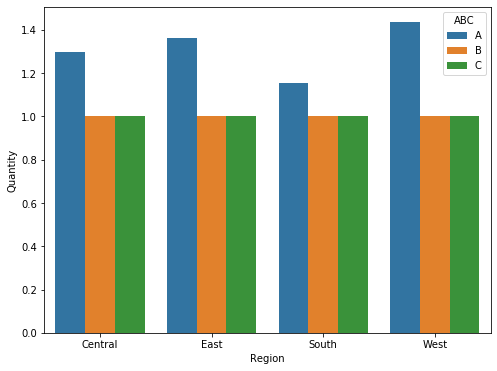

In [131]:
sns.barplot(data = abclines,x = 'Region',y = 'Quantity',hue = 'ABC',ci = None);